In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch.nn.functional as F
import numpy as np

# import some visualization tools
import matplotlib.pyplot as plt
from src.utils import plot_recon_wall

# **NN for MNIST Dataset**
___
We will be building a basic Neural Network (NN) architecture to reconstruct some images off of the MNIST data set, then we will try to apply the same model to reconstructs images on a more complex dataset like Fashion-MNIST.

We will start off by downloading the data, transforming it to tensors and then visualizing the images we have to work with. We note that the images are by default in grayscale color and are 28x28 pixels, we must keep this in mind when we build our architecture.

In [2]:
#Extract data and create the data loader objects
path = 'Data/'
transform = transforms.ToTensor()

train_data = datasets.MNIST(path, train=True, transform=transform, download=False)
test_data = datasets.MNIST(path, train=False, transform=transform, download=False)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

In [3]:
# Let's visualize the data.
display_loader = DataLoader(train_data, batch_size=10, shuffle=True, num_workers=2)
# Grab the first batch of 10 images
for images,labels in display_loader: 
    break

Label: [4 2 0 5 4 0 2 9 6 7]


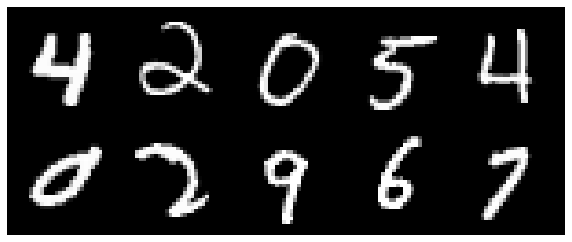

In [4]:
# Visualize the dataset
# Print the labels
print('Label:', labels.numpy())

# Print the images
im = make_grid(images, nrow=5)  # since there's 10 image per batch, we can display 5 values per row.
plt.figure(figsize=(10,7))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
plt.axis('off');

As we can see, the MNIST dataset contains a diversity of handwritten digits from 0-9.

# **NN Architecture**
___
We can now start building and testing our architecture. As previously mentioned, we want to have some inside knowledge about the images so that we can build a model that adapts to those parameters, for instance, the images are in grayscale, so that means that our NN should be aware of it by setting the input channel (in_ch) to one. The input channel is where you set whether or not the images are black and white (1 channel) or colored images (2 channels). Note that channels are only important when the input are solely images. We know that the original images are 28 x 28 pixels so our last layer should be adjusted so that the output images are in the same format.

For this architecture, I will be using a convination on fully connected linear layers (nn.Linear) with their biased turned off as they will be connected to normalization batch layers (nn.BatchNorm1d) and they have an associated bias to it. I will also be utilizing a leaky rectified linear unit activation function (nn.LeakyReLU) to ensure the outputs have a certain range of outputs. I will also be utilizing convolutional layers (nn.Conv2D) which help us filter very specific and strong features of an image. I've worked with a few different types of convolutional layers and learned about how they help us achieve better results from a [blog post](https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d) that can help you (me in this case) understand the benefit of all different kinds of covolutional layers as well as some of the math behind it. To get a better sense of convotional layers, I suggest reading this [post](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/). The last piece of the puzzel of this architecture is the usage of an interpolation function ([F.interpolate](https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html#torch.nn.functional.interpolate)). This gem down/up samples the result image to resemble the original image, in other words, it gets rid of any added "noise" that might of been created on the rendering process and it attempts to reshape to its original form (28 x 28 pixels with 1 input channel).

With a little background about the architecture jargon out of the way, we take a look at my architecture. I decided to have the image starts from linear layers and then through convolutional layers so that the math was a bit easier to keep up with, but there's nothing wrong with altering the order of the layers so long as you don't mind taking the time to do the math of each hyperparameter. Now, the number of hyper parameres I gave to each layer was inspired from inside knowledge of the dataset but you can play with it a bit to see if you can reach better results.

In [5]:
# Creating a customized NN architecture to autonomized process.
#NOTE: Model is only optimized to work with grayscale images, with 28x28 pixels.

class Model(nn.Module):

    def __init__(self, img_dim=28, in_ch=1, stride=2, kernel_size=4):
        """
        Parameters
        ----------
        img_dim    : int
            image size, only one dimension, assuming square ratio.
        in_ch      : int
            number of channels in input/output image.
        stride     : int
            size of stride (step size) for the kernel. Used in convolutional layers.
        kernel_size: int
            size of the kernel used in convolutional layers.
        """
        super(Model, self).__init__()
        self.img_dim = img_dim
        self.img_size = img_dim * img_dim
        self.in_ch = in_ch # This is important for the final layer of our architercture as we want it to output images in
                           # the same dimension as it was passed.
        
        # We'll start with linear layers
        self.linear = nn.Sequential(
            nn.Linear(img_dim * img_dim, 128, bias=False),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            
            nn.Linear(128, 16 * 4 * 4, bias=False),
            nn.BatchNorm1d(16 * 4 * 4),
            nn.LeakyReLU(),
            
            nn.Linear(16 * 4 * 4, 16 * 8 * 8, bias=False),
            nn.BatchNorm1d(16 * 8 * 8),
            nn.LeakyReLU(),
            
            nn.Linear(16 * 8 * 8, 16 * 10 * 10, bias=False),
            nn.BatchNorm1d(16 * 10 * 10),
            nn.LeakyReLU(),
            
            nn.Linear(16 * 10 * 10, 16 * 12 * 12, bias=False),
            nn.LeakyReLU()
        )
        
        # Then pass the images through convolutional layers
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(16, 16,  kernel_size, stride=stride, bias=False,
                               output_padding=1, padding=0),
            nn.Conv2d(16, 16, kernel_size, bias=False),
            nn.BatchNorm2d(16, momentum=0.005),
            nn.LeakyReLU(),

            nn.Conv2d(16, 8, kernel_size, bias=False),
            nn.BatchNorm2d(8, momentum=0.005),
            nn.LeakyReLU(),

            # Output layer
            nn.ConvTranspose2d(8, 8, kernel_size, stride=stride, bias=False,
                               output_padding=1, padding=0),
            nn.Conv2d(8, self.in_ch, 7),
            nn.Sigmoid()
        )
  
    # N, in_ch, W, H
    def forward(self, X):
        z = self.linear(X)
        z = z.view(-1, 16, 12, 12)
        z = self.conv(z)
        z = F.interpolate(z, size=(self.img_dim, self.img_dim), mode='nearest')
        return z

Some parameters you can play with:
* Different activation function (i.e. ReLU, sigmoid, softmax, tanh, etc).
* Number of linear and/or convolutional layers.
* Different values for hyperparameters on linear and convolutional layers (i.e. higher/lower in -> out channels for linear layers, etc).
* Kernel size on convolutional layers.
* Stride size on convolutional layers.
* Add different layers in between (i.e. drop out layers).
* As previously mentioned, mix order of layers.

In [6]:
# Instantiate the model
model = Model()
model

Model(
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=256, bias=False)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=256, out_features=1024, bias=False)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=1024, out_features=1600, bias=False)
    (10): BatchNorm1d(1600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=1600, out_features=2304, bias=False)
    (13): LeakyReLU(negative_slope=0.01)
  )
  (conv): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(4, 4), stri

# **Training and Testing**
As per usual, we will get started with the training and testing of the our model. For this model I chose to use a Binary Cross Entropy loss function (BCE) as a criterion (this is the same as our loss function but we refer to it as criterion when working with NNs). As our optimizer I chose Adam based on many blog post I've read and other projects, Adam is the most time efficient for image reconstructions. We will train and test the model for 50 epochs (iterations) and instead of printing out the loss as we go, we will plot it to have a better visualization of the train/test losses. Lastly, we will print out some of the recreated images the model is capable of doing.

In [7]:
#initialzie loss function and optimizer
criterion = nn.BCELoss(reduction='mean') # nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # you can play with the learning rate or even add weight_decay parameter

In [ ]:
#Train
from IPython.display import clear_output

epochs = 50
train_losses = []
test_losses = []

for i in range(epochs):
    plt.figure(figsize=(10, 8))
    clear_output(wait=True)
    
    for features, _ in train_loader:
        
        # Training
        features = features.view(-1, 28*28)
        
        #reconstruct
        output = model(features)
        output = output.view(-1, 28*28)

        #determine the loss
        loss = criterion(output, features)

        #backpropagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(loss) # Record loss
    #print(f"EPOCH: {i+1} \n\t CURRENT TRAINING LOSS: {loss.item()}")
  
  #TESTING
  
    with torch.no_grad():
        for test_feature, _ in test_loader:
            test_feature = test_feature.view(-1,28*28)
            output = model(test_feature)
            output = output.view(-1, 28*28)
        loss = criterion(output, test_feature)
        test_losses.append(loss)
        #print(f"\t CURRENT TEST LOSS: {loss.item()}")
        
    # Visualizing performace as we iterate
    plt.plot(train_losses, label='training loss')
    plt.plot(test_losses, label='test loss')
    plt.title('Loss per epoch')
    plt.ylabel('BCE')
    plt.xlabel('EPOCH')
    plt.legend()
    plt.show();

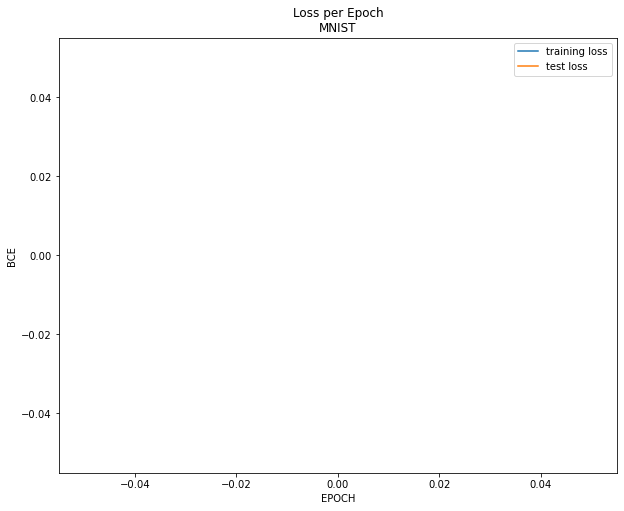

In [24]:
plt.figure(figsize=(10, 8))
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='test loss')
plt.title('Loss per Epoch\nMNIST')
plt.ylabel('BCE')
plt.xlabel('EPOCH')
plt.legend();

Some improvements you could try to improve the training rather than the architecture:
* Different criterion (i.e. MSE Loss, RMSE, L1, etc) but be mindful that we are recreating images so the units that each loss function might provide may be missleading so spending some time reading on what loss functions works best for image recreation is adviced.
* Train/test for more epochs. Note that I chose 50 for this data set because the testing error converged after about 30 epochs so I couldn't justify running it for longer.
* Try a different optimizer (i.e. gradient descent, gradien booster, etc).
* Use different parameters on Adam (i.e. learning rate, add a weight decay, etc).
* Use different batch size (higher batch sizes may result on higher runtime).

# **Visualizing the Reconstructed Images**
I created a visualization tool on the `src/utils.py` file that plots the images in a custom wall of any size. The first row contains the original MNIST image, the middle row shows the recreated images, and the last row shows the residual of the images. The residual row is a handy little feature as when the model gets more complex and makes better image reconstructions, the images can look nearly simialr, so visualizing the residuals helps us better visualize how accurate the images are and what small details it may not be performing well on. Let's now take a look at how our model really did.

In [11]:
'''
    Recall we created a display loader for visualizing purposes which loads in 
    a batch of 10 images at a time.
'''
display_loader = DataLoader(train_data, batch_size=50, shuffle=True, num_workers=2)

with torch.no_grad():
    for features, labels in display_loader: 
        reconstruction = model(features.view(-1, 28 * 28))
        break

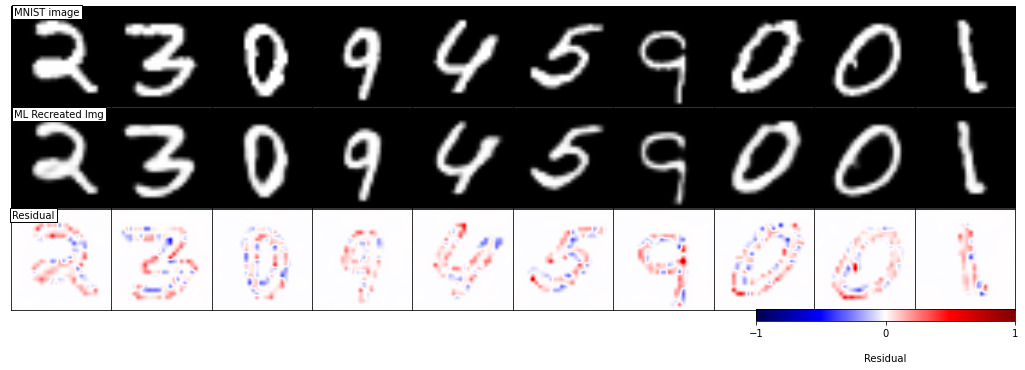

In [12]:
plot_recon_wall(features, reconstruction, cmap='gray', norm=False, ncols=10, savename='MNIST_wall_plot.png', savefig=True)

# **Fashion-MNIST Dataset NN**
---
We will now transition to a more complex dataset while using the exact same architecture and training/testing layout. The [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) consists of a training set of 60,000 examples and a test set of 10,000 examples where each example is a 28x28 grayscale image. Each images is also associated with a label from 10 different classes. This is the main reason we added convolutional layers, to be able to handle that complexity.

In [13]:
training_set = datasets.FashionMNIST(path, train=True, transform=transform, download=False)
test_set = datasets.FashionMNIST(path, train=False, transform=transform, download=False)

train_loader = DataLoader(training_set, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

Class:  Sandal Coat Pullover Coat Trouser Coat Dress T-shirt Boot Sandal


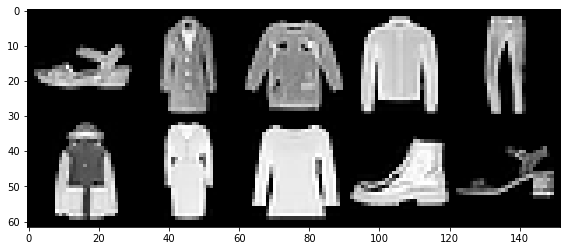

In [14]:
#visulize the Fashion MNIST data
class_labels = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot']
fashion_display_set = DataLoader(training_set, batch_size=10, shuffle=True)

# Grab the first batch of 10 images
for features, labels in fashion_display_set:
    break

# Print the labels
print('Class: ', *np.array([class_labels[i] for i in labels]))

# Print the images
im = make_grid(features, nrow=5)  # since there's 10 image per batch
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

**Architecture**

The model will be *exactly* the same as the MNIST data set since the feautures are similar.

In [15]:
fashion_model = Model()
fashion_model

Model(
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=256, bias=False)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=256, out_features=1024, bias=False)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=1024, out_features=1600, bias=False)
    (10): BatchNorm1d(1600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=1600, out_features=2304, bias=False)
    (13): LeakyReLU(negative_slope=0.01)
  )
  (conv): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(4, 4), stri

In [16]:
# Initialzie loss function and optimizer
criterion2 = nn.BCELoss(reduction='mean') # nn.MSELoss()
optimizer2 = torch.optim.Adam(fashion_model.parameters(), lr=1e-4)

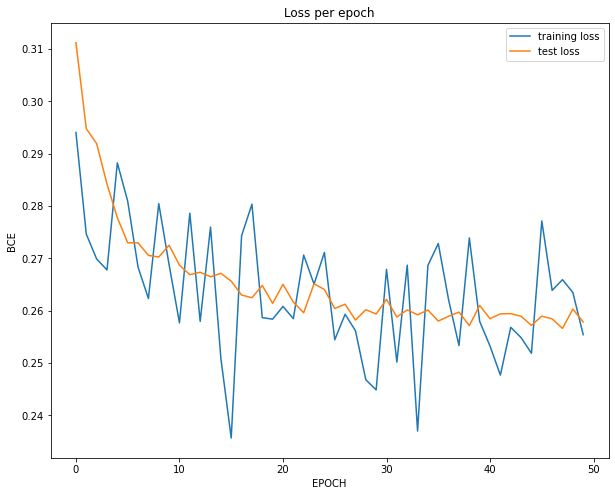

In [17]:
#Train
from IPython.display import clear_output

ftrain_losses = []
ftest_losses = []

for i in range(epochs):
    plt.figure(figsize=(10, 8))
    clear_output(wait=True)
    
    for features, _ in train_loader:
        
        # Training
        features = features.view(-1, 28*28)
        
        #reconstruct
        output = fashion_model(features)
        output = output.view(-1, 28*28)

        #determine the loss
        loss = criterion2(output, features)

        #backpropagate
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
    ftrain_losses.append(loss) # Record loss
  
  #TESTING
  
    with torch.no_grad():
        for test_feature, _ in test_loader:
            test_feature = test_feature.view(-1,28*28)
            output = fashion_model(test_feature)
            output = output.view(-1, 28*28)
        loss = criterion2(output, test_feature)
        ftest_losses.append(loss)
        
    # Visualizing performace as we iterate
    plt.plot(ftrain_losses, label='training loss')
    plt.plot(ftest_losses, label='test loss')
    plt.title('Loss per epoch')
    plt.ylabel('BCE')
    plt.xlabel('EPOCH')
    plt.legend()
    plt.show();

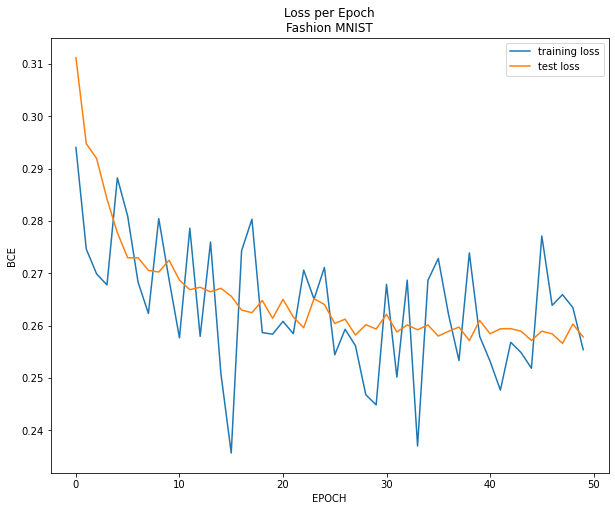

In [27]:
plt.figure(figsize=(10, 8))
plt.plot(ftrain_losses, label='training loss')
plt.plot(ftest_losses, label='test loss')
plt.title('Loss per Epoch\nFashion MNIST')
plt.ylabel('BCE')
plt.xlabel('EPOCH')
plt.legend();
plt.savefig('loss_per_epoch', dpi=300, bbox_inches='tight')

In [21]:
fashion_display_set = DataLoader(test_set, batch_size=100, shuffle=True)

with torch.no_grad():
    for features,labels in fashion_display_set:
        reconstruction = fashion_model(features.view(-1,28*28)) 
        break

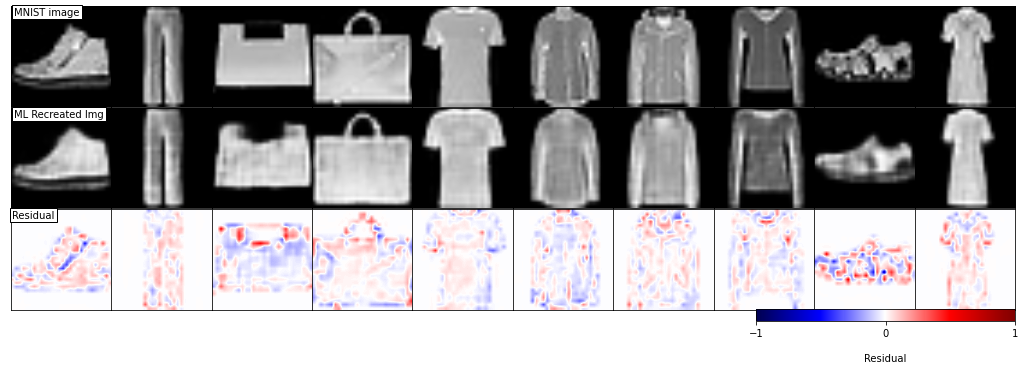

In [23]:
plot_recon_wall(features, reconstruction, cmap='gray', norm=False, ncols=10, 
                savename='Fashion_MNIST_wall_plot.png', savefig=True)